### Vehicle Collision Analysis

Analyst: Daniel Elkin <br />
Date: 06/12/2019

In [1]:
import numpy as np
import matplotlib as plt
import pandas as pd
from scipy.stats import ttest_ind

In [2]:
%matplotlib inline

### Contents:
* [I. Data Loading and Validation](#load)
* [II. Collision Times](#times)
* [III. Vehicle Types](#types)
    * [a. Fatalities](#fatalities)
    * [b. Injuries](#injuries)

#### I. Data Loading and Validation <a id="load"/>

First we'll load the data.

In [3]:
data_file = "data/NYPD_Motor_Vehicle_Collisions.csv"

rows = !wc -l < $data_file
rows = int(rows[0])

print(f"There are {rows} rows in the data file.")

There are 1509271 rows in the data file.


In [4]:
# the columns of interest for the questions in the prompt
cols = [
    "DATE",
    "TIME",
    "BOROUGH",                                          
    "NUMBER OF PERSONS INJURED",        
    "NUMBER OF PERSONS KILLED",       
    "NUMBER OF PEDESTRIANS INJURED",    
    "NUMBER OF PEDESTRIANS KILLED",     
    "NUMBER OF CYCLIST INJURED",        
    "NUMBER OF CYCLIST KILLED",         
    "NUMBER OF MOTORIST INJURED",       
    "NUMBER OF MOTORIST KILLED",        
    "UNIQUE KEY",                       
    "VEHICLE TYPE CODE 1",              
    "VEHICLE TYPE CODE 2",              
    "VEHICLE TYPE CODE 3",              
    "VEHICLE TYPE CODE 4",              
    "VEHICLE TYPE CODE 5"
]   

df = pd.read_csv(data_file, 
                 parse_dates=[["DATE", "TIME"]],
                 usecols=cols)

In [5]:
# confirm we've loaded all rows
len(df)

1509269

Next, we'll rename the columns for readability and use only the data from 2018.

In [6]:
df.rename(columns=lambda c: c.lower().replace(" ", "_"), inplace=True)
df = df[df.date_time.dt.year == 2018]

Let's examine the remaining data for potential issues.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231485 entries, 269 to 320494
Data columns (total 16 columns):
date_time                        231485 non-null datetime64[ns]
borough                          149173 non-null object
number_of_persons_injured        231480 non-null float64
number_of_persons_killed         231471 non-null float64
number_of_pedestrians_injured    231485 non-null int64
number_of_pedestrians_killed     231485 non-null int64
number_of_cyclist_injured        231485 non-null int64
number_of_cyclist_killed         231485 non-null int64
number_of_motorist_injured       231485 non-null int64
number_of_motorist_killed        231485 non-null int64
unique_key                       231485 non-null int64
vehicle_type_code_1              230088 non-null object
vehicle_type_code_2              182463 non-null object
vehicle_type_code_3              13853 non-null object
vehicle_type_code_4              2872 non-null object
vehicle_type_code_5              762 non-null o

In [8]:
# ensure that the unique key is really unique
assert len(df.unique_key) == len(df.unique_key.unique())

In [9]:
# see how many null values we have
df.isnull().sum()

date_time                             0
borough                           82312
number_of_persons_injured             5
number_of_persons_killed             14
number_of_pedestrians_injured         0
number_of_pedestrians_killed          0
number_of_cyclist_injured             0
number_of_cyclist_killed              0
number_of_motorist_injured            0
number_of_motorist_killed             0
unique_key                            0
vehicle_type_code_1                1397
vehicle_type_code_2               49022
vehicle_type_code_3              217632
vehicle_type_code_4              228613
vehicle_type_code_5              230723
dtype: int64

We have 231,485 collisions in the dataset. We've confirmed that the data is complete for the `date_time` and `unique_key` columns. We'll further examine and clean the data below.

#### II. Collision times <a id="times"/>

We'll create a new dataframe with only the columns needed to answer the question of when collisions occur.

In [72]:
# subset the fields needed
df1 = df[["date_time", "unique_key", "borough"]].copy()

# add a derived column for day of week
df1["day_of_week"] = df1.date_time.dt.weekday_name

# make the time of the collision the index
df1.set_index("date_time", inplace=True)

df1.head()

,unique_key,borough,day_of_week
date_time,,,
2018-12-29 19:45:00,4055860,NaN,Saturday
2018-12-24 10:00:00,4055249,NaN,Monday
2018-12-17 14:30:00,4047978,NaN,Monday
2018-12-31 00:00:00,4055273,BRONX,Monday
2018-12-31 00:00:00,4055449,BROOKLYN,Monday


We'll bin the collisions by the hour at which they occur and plot them.

<a id='by-hour'></a>

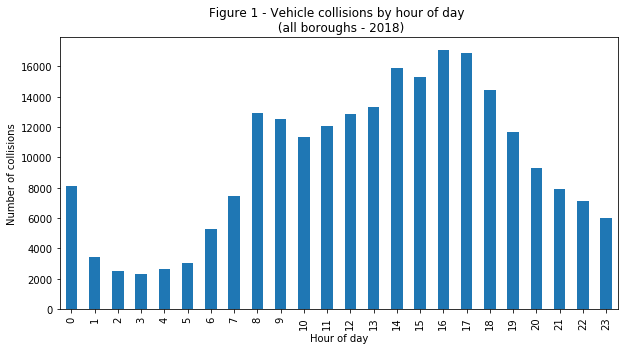

In [79]:
group = df1.groupby(df1.index.hour).count().unique_key
ax = group.plot(kind="bar", 
                figsize=(10, 5),
                title="Figure 1 - Vehicle collisions by hour of day \n (all boroughs - 2018)")

ax.set_xlabel("Hour of day")
ax.set_ylabel("Number of collisions")
ax.figure.savefig("figures/fig_1.png")

In [21]:
print(f"Mean collisions in early morning: {group[1:6].sum() / 5}")
print(f"Mean collisions in afternoon rush hour: {group[16:18].sum() / 2}")

Mean collisions in early morning: 2788.8
Mean collisions in afternoon rush hour: 16980.5


We do not have complete data for the boroughs in which collisions occur, but we can visualize the data we do have by borough as well.

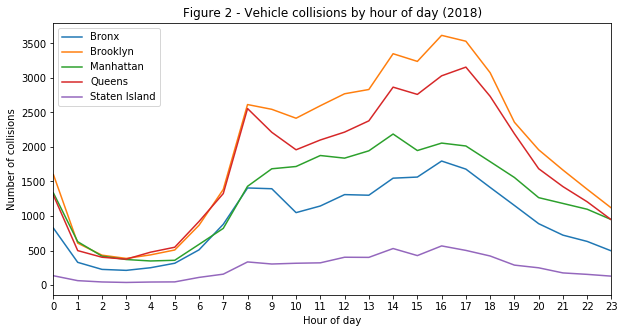

In [80]:
group = (df1.groupby([df1.index.hour, "borough"])
         .unique_key
         .count()
         .unstack())

ax = group.plot(figsize=(10, 5), 
                xticks=range(0, 24), 
                title="Figure 2 - Vehicle collisions by hour of day (2018)")
ax.set_xlabel("Hour of day")
ax.set_ylabel("Number of collisions")

# rename the legends so values are not all uppercase 
boroughs = [str(b).title() 
            for b in df1.borough.dropna().unique()]
ax.legend(boroughs)
ax.figure.savefig("figures/fig_2.png")

We will discuss further in the conclusion, but the graphs reveal that most accidents occur during the day, particularly between the hours of 4:00 and 6:00pm.

<a id="days" />

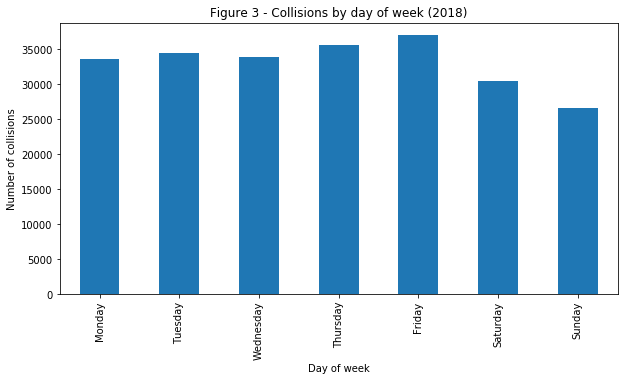

In [95]:
# order the grouped dataframe by day of week
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
group = (df1.groupby(["day_of_week"])
         .count()
         .unique_key
         .reindex(days))

plt.pyplot.tight_layout()
ax = group.plot(figsize=(10, 5), 
           kind="bar", 
           title="Figure 3 - Collisions by day of week (2018)")

ax.set_xlabel("Day of week")
ax.set_ylabel("Number of collisions")
ax.figure.savefig("figures/fig_3.png")

More collisions also occur on weekdays than weekends.

In [16]:
print(f"Average collisions on weekdays {group[:5].sum() / 5}")
print(f"Average collisions on weekends {group[5:].sum() / 2}")

Average collisions on weekdays 34887.4
Average collisions on weekends 28524.0


#### III. Vehicle type <a id="types" />

#### a. Data preparation

We'll create a dataframe containing the relevant fields for answering the second question regarding the effect of vehicle type on injury and mortality rates.

In [7]:
df2 = df.drop(["date_time", "borough"], axis=1).copy()
df2 = df2.set_index("unique_key")
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231485 entries, 4055860 to 3820878
Data columns (total 13 columns):
number_of_persons_injured        231480 non-null float64
number_of_persons_killed         231471 non-null float64
number_of_pedestrians_injured    231485 non-null int64
number_of_pedestrians_killed     231485 non-null int64
number_of_cyclist_injured        231485 non-null int64
number_of_cyclist_killed         231485 non-null int64
number_of_motorist_injured       231485 non-null int64
number_of_motorist_killed        231485 non-null int64
vehicle_type_code_1              230088 non-null object
vehicle_type_code_2              182463 non-null object
vehicle_type_code_3              13853 non-null object
vehicle_type_code_4              2872 non-null object
vehicle_type_code_5              762 non-null object
dtypes: float64(2), int64(6), object(5)
memory usage: 24.7+ MB


We note that there are 5 vehicle type fields for each collision and that the number of not-null values in columns 1 and 2 are an order of magnitude greater than the number of not-null values in columns 3, 4 and 5. In the following analysis, we'll examine just `vehicle_type_code_1` and `vehicle_type_code_2` in order to have a more manageble number of vehicle-type combinations to examine.

We create a new column called `vehicle_type` that contains just `vehicle_type_code_1` in the case that `vehicle_type_code_2` is null, and otherwise contains a sorted concatenation of the two fields.

In [15]:
# drop the approximately 1300 instances where there are no vehicle types
df2.dropna(subset=["vehicle_type_code_1"], inplace=True)

# combine the first two vehicle type columns with a "+" as the delimiter
df2["vehicle_type"] = (np.where(df2.vehicle_type_code_1 < df2.vehicle_type_code_2, 
                                   df2.vehicle_type_code_1.str.lower() + " and " + df2.vehicle_type_code_2.str.lower(), 
                                   df2.vehicle_type_code_2.str.lower() + " and " + df2.vehicle_type_code_1.str.lower()))

# if the column is null, then the second vehicle type is null, so use the first type
df2["vehicle_type"] = (np.where(df2.vehicle_type_code_2.isna(), 
                                  df2.vehicle_type_code_1.str.lower() + " only",
                                  df2.vehicle_type))

In [83]:
df2[["vehicle_type_code_1", "vehicle_type_code_2", "vehicle_type"]].head(10)

,vehicle_type_code_1,vehicle_type_code_2,vehicle_type
unique_key,,,
4055860,Sedan,NaN,sedan only
4055249,Sedan,NaN,sedan only
4055273,Sedan,Station Wagon/Sport Utility Vehicle,sedan and station wagon/sport utility vehicle
4055449,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,station wagon/sport utility vehicle and statio...
4055005,Van,Sedan,sedan and van
4055499,Station Wagon/Sport Utility Vehicle,NaN,station wagon/sport utility vehicle only
4055512,Station Wagon/Sport Utility Vehicle,Sedan,sedan and station wagon/sport utility vehicle
4060683,Station Wagon/Sport Utility Vehicle,Sedan,sedan and station wagon/sport utility vehicle
4062834,Pick-up Truck,NaN,pick-up truck only


#### b. Mortality

We'll first examine the total number of fatalities by vehicle type.

Total number of fatalities: 223


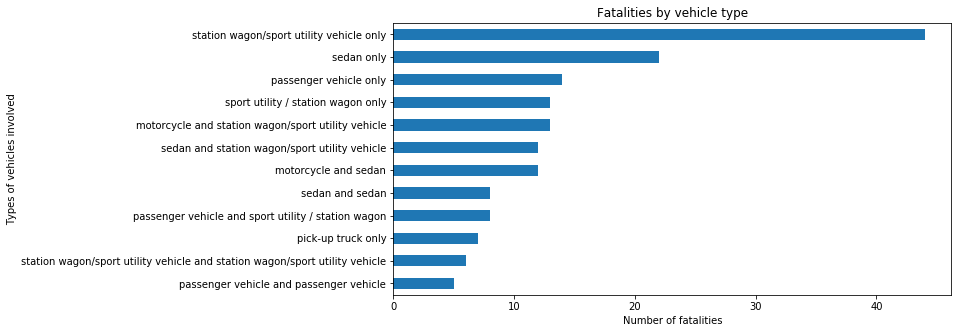

In [118]:
grouped = (df2.groupby("vehicle_type")
               .number_of_persons_killed
               .sum()
               .sort_values(ascending=False))

total_fatalities = int(grouped.sum())
print(f"Total number of fatalities: {total_fatalities}")

# subset to cases where there were at least 5 fatalities for the type
grouped = grouped[grouped >= 5]

# plot
title = "Fatalities by vehicle type"
ax = (grouped
      .iloc[::-1] # put highest number at the top
      .plot(figsize=(10, 5), 
            kind="barh",
            title=title))

ax.set_xlabel("Number of fatalities")
_ = ax.set_ylabel("Types of vehicles involved")
# print("\nFatalities by vehicle type:")
# print(grouped.head())

We see that there were 223 total fatalities and that the top vehicle type was a single vehicle (SUV/station wagon, sedan or passenger vehicle). These appear to be cases where a pedestrian was struck and killed. Let's examine further to confirm.

Number of pedestrian fatalities: 116
Number of motorist fatalities: 97
Number of cyclist fatalities: 10


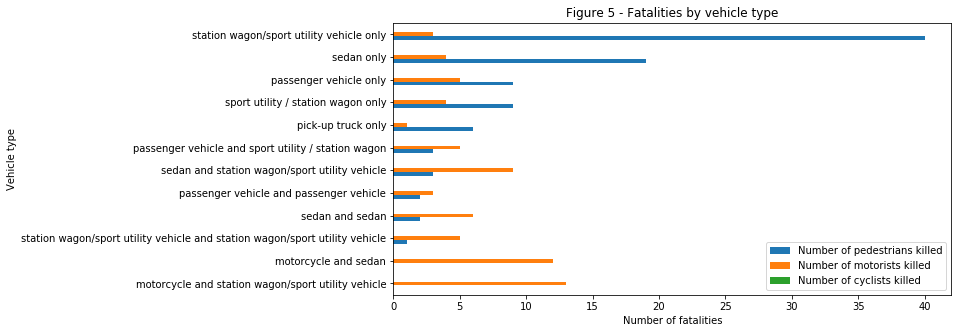

In [123]:
print(f"Number of pedestrian fatalities: {int(df2.number_of_pedestrians_killed.sum())}")
print(f"Number of motorist fatalities: {int(df2.number_of_motorist_killed.sum())}")
print(f"Number of cyclist fatalities: {int(df2.number_of_cyclist_killed.sum())}")

groups = ["number_of_pedestrians_killed", "number_of_motorist_killed", "number_of_cyclist_killed"]
dff = (df2[(df2.vehicle_type.isin(grouped.index))]
           .groupby(["vehicle_type"])
      )[groups].apply(lambda x : x.astype(int).sum())

ax = (dff.sort_values("number_of_pedestrians_killed", ascending=False)
     .iloc[::-1]
     .plot(figsize=(10, 5), 
           kind="barh",
           title="Figure 5 - Fatalities by vehicle type"))
 
ax.set_xlabel("Number of fatalities")
ax.set_ylabel("Vehicle type")
ax.legend(["Number of pedestrians killed", 
           "Number of motorists killed", 
           "Number of cyclists killed"])
ax.figure.savefig("figures/fig_5.png")

The cases in which only a single vehicle is involved are typically pedestrian deaths. 

We also see a that a large number of fatalities included a motorcycle. Let's further examine this.

In [125]:
motorcycles = df2[df2.vehicle_type.str.contains("motorcycle")]
others = df2[~df2.vehicle_type.str.contains("motorcycle")]

percent_motorcycle = len(motorcycles) / len(df2) * 100
percent_motorcycle_fatal = int(motorcycles.number_of_persons_killed.sum() / total_fatalities * 100)

motorcycle_mean_fatalities = motorcycles.number_of_persons_killed.mean()
others_mean_fatalities = others.number_of_persons_killed.mean()

motorcycle_fatal = motorcycles[motorcycles.number_of_persons_killed > 0]
motorcycle_fatal_percent = len(motorcycle_fatal) / len(motorcycles) * 100

print(f"Percent of collisions involving a motorcycle: {percent_motorcycle:.2}%")
print(f"Percent of fatalities involving a motorcycle: {percent_motorcycle_fatal}%")
print(f"Percent of motorcycle collisions that involve a fatality: {motorcycle_fatal_percent:.2}%")
print()
print(f"Mean fatalities for collisions involving a motorcycle: {motorcycle_mean_fatalities:.2}")
print(f"Mean fatalities for collisions not involving a motorcycle: {others_mean_fatalities:.2}")

Percent of collisions involving a motorcycle: 0.88%
Percent of fatalities involving a motorcycle: 14%
Percent of motorcycle collisions that involve a fatality: 1.6

Mean fatalities for collisions involving a motorcycle: 0.016
Mean fatalities for collisions not involving a motorcycle: 0.00083


It appears that collisions involving a motorcycle are much more likely to result in a fatality. Let's conduct a t-test to confirm that this is a signifincat result. 

In [167]:
target = "number_of_persons_killed"
ttest_ind(motorcycles.dropna(subset=[target]).number_of_persons_killed, 
          others.dropna(subset=[target]).number_of_persons_killed,
          equal_var=False)

Ttest_indResult(statistic=5.3329578124055725, pvalue=1.0745632117003407e-07)

We find that collisions involving motorcycles are more likely to include a fatality than collisions involving other vehicle types.

In [20]:
vehicles = df2[df2.vehicle_type.str.contains("sedan")]
deaths = vehicles[vehicles.number_of_persons_killed > 1]
len(deaths) / len(vehicles) * 100

0.001010233667047188

In [109]:
def get_rates(row, mortality=True):
    """
    Returns the total mortality or injury rates for a vehicle type (float)
    
    Args:
        row: Series indexed by type of vehicle (str)
        mortality: bool indicating whether to return mortality or injury rates
    """
    
    # extract the vehicle name from the index
    vehicle = row.name
    
    # get all collisions that include the vehicle type
    collisions = (
        df2[(df2.vehicle_type_code_1.str.lower() == vehicle) |
            (df2.vehicle_type_code_2.str.lower() == vehicle) |
            (df2.vehicle_type_code_3.str.lower() == vehicle) |
            (df2.vehicle_type_code_4.str.lower() == vehicle) |
            (df2.vehicle_type_code_5.str.lower() == vehicle)
           ]
    )
    
    # get all collisions for the vehicle type that include a fatality or injury
    if mortality:
        collisions_of_type = collisions[collisions.number_of_persons_killed > 0]
    else:
        collisions_of_type = collisions[collisions.number_of_persons_injured > 0]
        
    # calculate mortality or injury rate
    rate = len(collisions_of_type) / len(collisions) * 100
    
    return round(rate, 2)

In [110]:
top_vehicles = (df2.vehicle_type_code_1.str.lower()
 .to_frame()
 .vehicle_type_code_1
 .value_counts()[:20]
 .to_frame())

In [120]:
mortality = top_vehicles.apply(get_rates, 
                   args=("mortality",), 
                   axis=1).sort_values(ascending=False)
mortality

motorcycle                             1.55
bike                                   0.17
vn                                     0.12
station wagon/sport utility vehicle    0.11
convertible                            0.11
bus                                    0.11
pick-up truck                          0.10
box truck                              0.08
bu                                     0.08
tractor truck diesel                   0.08
tk                                     0.07
sport utility / station wagon          0.07
passenger vehicle                      0.06
sedan                                  0.06
taxi                                   0.04
van                                    0.04
pk                                     0.00
ds                                     0.00
dump                                   0.00
ambulance                              0.00
dtype: float64

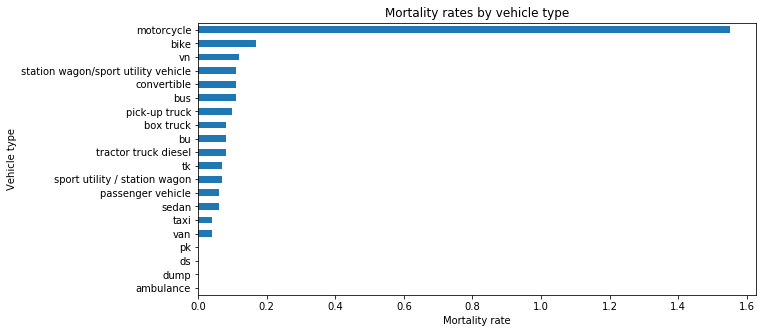

In [127]:
ax = (mortality
 .iloc[::-1] # put highest number at the top
 .plot(figsize=(10, 5), 
       kind="barh",
       title="Mortality rates by vehicle type"))

ax.set_xlabel("Mortality rate")
ax.set_ylabel("Vehicle type")
ax.figure.savefig("figures/mort.png")

In [128]:
injury = top_vehicles.apply(
    get_rates, 
    args=(False,), 
    axis=1).sort_values(ascending=False)

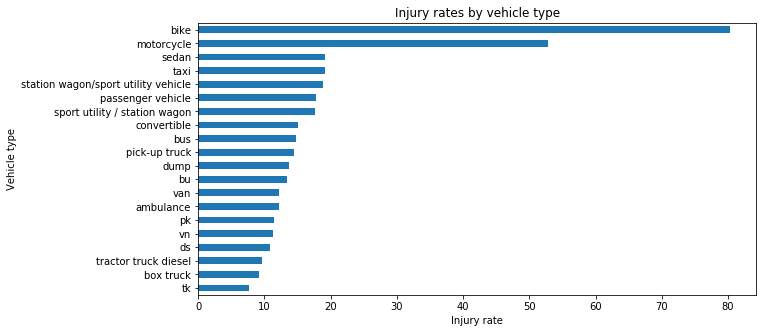

In [129]:
ax = (injury
 .iloc[::-1] # put highest number at the top
 .plot(figsize=(10, 5), 
       kind="barh",
       title="Injury rates by vehicle type"))

ax.set_xlabel("Injury rate")
ax.set_ylabel("Vehicle type")
ax.figure.savefig("figures/inj.png")

#### c. Injury

We'll next look at the total number of injuries by vehicle type.

<a id="fig6" />

Total number of injuries: 60889
Number of collisions involving injury: 44575



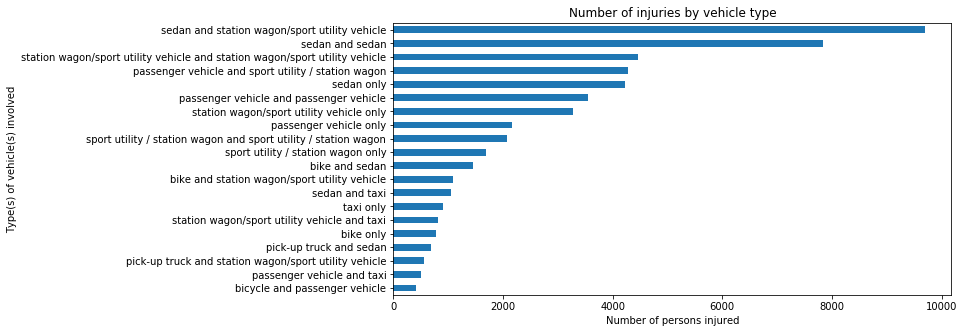

In [128]:
grouped = (df2.groupby("vehicle_type")
           .number_of_persons_injured
           .sum()
           .sort_values(ascending=False))

total_injuries = int(grouped.sum())
collision_injuries = len(df2[df2.number_of_persons_injured > 0])
print(f"Total number of injuries: {total_injuries}")
print(f"Number of collisions involving injury: {collision_injuries}\n")

title = "Number of injuries by vehicle type"
ax = (grouped.head(20)
      .iloc[::-1] # put highest number at the top
      .plot(figsize=(10, 5), 
            kind="barh",
            title=title)
     )
ax.set_xlabel("Number of persons injured")
_ = ax.set_ylabel("Type(s) of vehicle(s) involved")
# grouped.head(20)

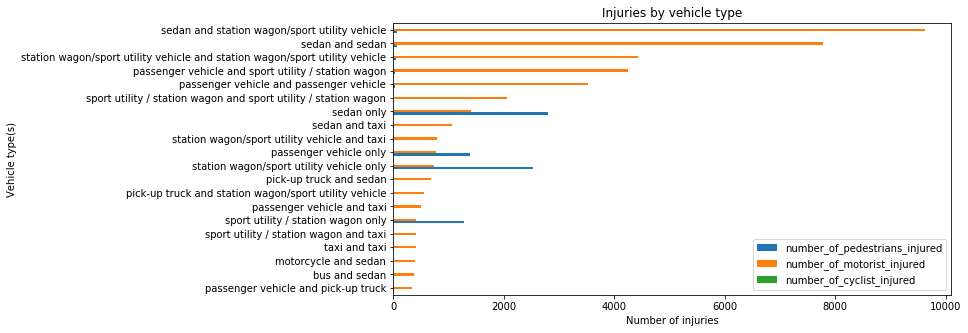

In [130]:
dfi = (df2.groupby(["vehicle_type"])
          )["number_of_pedestrians_injured", 
            "number_of_motorist_injured", 
            "number_of_cyclist_injured"].apply(lambda x : x.astype(int).sum())

dfi = dfi.sort_values("number_of_motorist_injured", ascending=False).head(20)

ax = dfi.iloc[::-1].plot(figsize=(10, 5), 
           kind="barh",
           title="Injuries by vehicle type")

ax.set_xlabel("Number of injuries")
_ = ax.set_ylabel("Vehicle type(s)")

Let's also examine the mean number of injuries by vehicle type, looking only at vehicle types that occur in at least .1% of collisions.

In [132]:
inj = (df2.groupby("vehicle_type")
       .vehicle_type
       .count())
inj = inj[inj >= .001 * len(df2)]
# print("Subset of vehicle types:")
# inj.head()

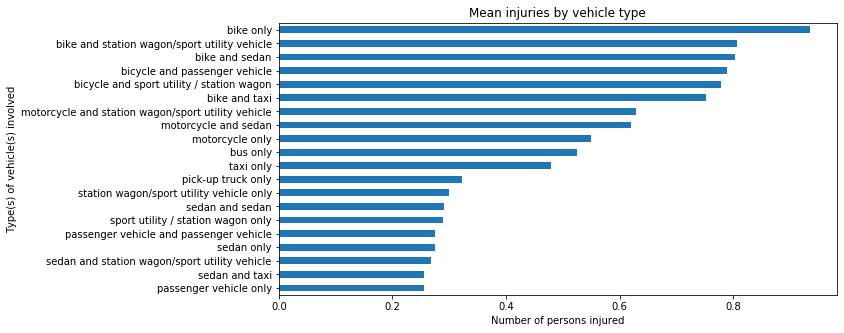

In [133]:
dfi = df2[df2.vehicle_type.isin(inj.index)]
grouped = (dfi
 .groupby("vehicle_type")
 .number_of_persons_injured
 .mean()
 .sort_values(ascending=False)
)

title = "Mean injuries by vehicle type"
ax = (grouped.head(20)
      .iloc[::-1] # put highest number at the top
      .plot(figsize=(10, 5), 
            kind="barh",
            title=title)
     )
ax.set_xlabel("Number of persons injured")
_ = ax.set_ylabel("Type(s) of vehicle(s) involved")
# grouped.head(10)

In [150]:
bikes = df2[(df2.vehicle_type.str.contains("bike")) | (df2.vehicle_type.str.contains("bicycle"))]
bike_injuries = len(bikes[bikes.number_of_persons_injured > 0]) / len(bikes)

motorcycle_injuries = len(motorcycles[motorcycles.number_of_persons_injured > 0]) / len(motorcycles)

print(f"Percent collisions involving bicycles that include injury: {bike_injuries:.2}%")
print(f"Percent collisions involving motorcycles that include injury: {motorcycle_injuries:.2}%")

Percent collisions involving bicycles that include injury: 0.79%
Percent collisions involving motorcycles that include injury: 0.53%


We see that accidents involving bicycles and motorcycles often result in injury. Let's also look at the mean number of injuries in only those cases in which an injury occurs.

<a id="fig8" />

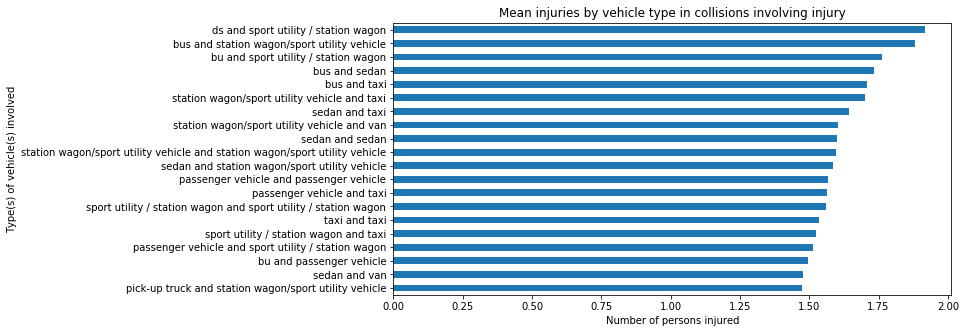

In [135]:
dfi = df2[df2.vehicle_type.isin(inj.index)]
grouped = (dfi[dfi["number_of_persons_injured"] >= 1]
 .groupby("vehicle_type")
 .number_of_persons_injured
 .mean()
 .sort_values(ascending=False)
)

title = "Mean injuries by vehicle type in collisions involving injury"
ax = (grouped.head(20)
      .iloc[::-1] # put highest number at the top
      .plot(figsize=(10, 5), 
            kind="barh",
            title=title)
     )
ax.set_xlabel("Number of persons injured")
_ = ax.set_ylabel("Type(s) of vehicle(s) involved")
# print(grouped.head(10))

The mean number of injuries does not exceed 2, so there does not appear to be any vehicle type for which accidents result in an unusually high number of injuries.

We do see that buses and taxis are prevalent in the above plot. Let's see if collisions involving at least one injury and a taxi have higher numbers of injuries on average than collisions not involving taxis.

In [174]:
taxi = df2[(df2.vehicle_type.str.contains("taxi")) & (df2.number_of_persons_injured > 0)]
non_taxi = df2[~df2.vehicle_type.str.contains("taxi") & (df2.number_of_persons_injured > 0)]

In [175]:
print(f"Mean injuries for accidents with a taxi and at least one injury: {taxi.number_of_persons_injured.mean():.3}")
print(f"Mean injuries for accidents with no taxi and at least one injury: {non_taxi.number_of_persons_injured.mean():.3}")

Mean injuries for accidents with a taxi and at least one injury: 1.4
Mean injuries for accidents with no taxi and at least one injury: 1.36


In [176]:
target = "number_of_persons_injured"
ttest_ind(taxi.dropna(subset=[target]).number_of_persons_injured, 
          non_taxi.dropna(subset=[target]).number_of_persons_injured,
          equal_var=False)

Ttest_indResult(statistic=2.3288224759851555, pvalue=0.01991737443200112)